# Import necessary libraries

In [26]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

Importing plotly failed. Interactive plots will not work.


# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.


In [27]:
sales_df = pd.read_csv('./data/retail_sales.csv', index_col='date', parse_dates=True)

In [28]:
sales_df.head()

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [29]:
df = sales_df.reset_index()

In [30]:
df.head()

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


In [10]:
df=df.rename(columns={'date':'ds', 'sales':'y'})

In [11]:
df.head()

,ds,y
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

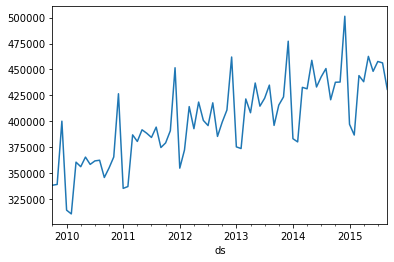

In [12]:
df.set_index('ds').y.plot()

In [13]:
df['y'] = np.log(df['y'])

In [14]:
df.tail()

,ds,y
67,2015-05-01,13.044650
68,2015-06-01,13.013060
69,2015-07-01,13.033991
70,2015-08-01,13.030993
71,2015-09-01,12.973671


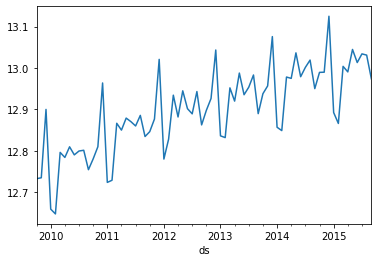

In [15]:
df.set_index('ds').y.plot()

As you can see in the above chart, the plot looks the same as the first one but just at a different scale.

# Running Prophet

In [23]:


model = Prophet()
model.fit(df);

NameError: name 'Prophet' is not defined

In [21]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

NameError: name 'model' is not defined

To forecast this future data, we need to run it through Prophet's model.

In [22]:
forecast = model.predict(future)

NameError: name 'model' is not defined

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [19]:
forecast.tail()

NameError: name 'forecast' is not defined

We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

In [ ]:
model.plot(forecast);

Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself.  The next section describes how I build my own visualization for Prophet modeling 

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ```ds```

In [ ]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [ ]:
viz_df = sales_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

If we look at the ```head()```, we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's ```exp``` function to do that.

In [ ]:
viz_df.head()

In [ ]:
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

In [ ]:
viz_df.head()

Let's take a look at the ```sales``` and ```yhat_rescaled``` data together in a chart.

In [ ]:
viz_df[['sales', 'yhat_rescaled']].plot()

In [ ]:
sales_df.index = pd.to_datetime(sales_df.index) #make sure our index as a datetime object
connect_date = sales_df.index[-2] #select the 2nd to last date

Using the ```connect_date``` we can now grab only the model data that after that date (you'll see why in a minute). To do this, we'll mask the forecast data.

In [ ]:
mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]

In [ ]:
predict_df.head()

Now, let's build a dataframe to use in our new visualization. We'll follow the same steps we did before.

In [ ]:
viz_df = sales_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])

Now, if we take a look at the ```head()``` of ```viz_df``` we'll see 'NaN's everywhere except for our original data rows.  

In [ ]:
viz_df.head()

If we take a look at the ```tail()``` of the ```viz_df``` you'll see we have data for the forecasted data and NaN's for the original data series.

In [ ]:
viz_df.tail()

## time to plot

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.sales)
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (Orange) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot

This visualization is much better (in my opinion) than the default fbprophet plot. It is much easier to quickly understand and describe what's happening. The orange line is actual sales data and the black dotted line is the forecast. The gray shaded area is the uncertaintity estimation of the forecast.

In [ ]:
import pandas as pd
import numpy as np
import pyflux as pf
import matplotlib.pyplot as plt
from fbprophet import Prophet
    
%matplotlib inline
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

### Load the data

For this work, we're going to use the same retail sales data that we've used before. It can be found in the examples directory of this repository.

In [ ]:
sales_df = pd.read_csv('../data/sales.csv', index_col='date', parse_dates=True)

In [ ]:
sales_df.head()

Like all good modeling projects, we need to take a look at the data to get an idea of what it looks like.

In [ ]:
sales_df.plot()

In [ ]:
# Prep data for prophet and run prophet
df = sales_df.reset_index()
df=df.rename(columns={'date':'ds', 'sales':'y'})

model = Prophet(weekly_seasonality=True)
model.fit(df);
future = model.make_future_dataframe(periods=24, freq = 'm')

forecast = model.predict(future)
model.plot(forecast);

With our prophet model ready for comparison, let's build a model with pyflux's dynamic linear regresion model.


### More Data Viz 

In [ ]:
diff_log = pd.DataFrame(np.diff(np.log(sales_df['sales'].values)))
diff_log.index = sales_df.index.values[1:sales_df.index.values.shape[0]]
diff_log.columns = ["Sales DiffLog"]


In [ ]:
sales_df['logged']=np.log(sales_df['sales'])

In [ ]:
sales_df.tail()

In [ ]:
sales_df.plot(subplots=True)

In [ ]:
pf.acf_plot(diff_log.values.T[0])
pf.acf_plot(np.square(diff_log.values.T[0]))

We can see that at a lag of 1 and 2 months, there are positive correlations for sales but as time goes on, that correlation drops quickly to a negative correlation that stays in place over time, which hints at the fact that there are some autoregressive effects within this data.  

Because of this fact, we can start our modeling by using an ARMA model of some sort.

In [ ]:
Logged = pd.DataFrame(np.log(sales_df['sales']))
Logged.index = pd.to_datetime(sales_df.index)
Logged.columns = ['Sales - Logged']

In [ ]:
Logged.head()

In [ ]:
modelLLT = pf.LLT(data=Logged)

In [ ]:
x = modelLLT.fit()
x.summary()

In [ ]:
model.plot_fit(figsize=(20,10))

In [ ]:
modelLLT.plot_predict_is(h=len(Logged)-1, figsize=(20,10))

In [ ]:
predicted = modelLLT.predict_is(h=len(Logged)-1)
predicted.columns = ['Predicted']

In [ ]:
predicted.tail()

In [ ]:
np.exp(predicted).plot()

In [ ]:
sales_df_future=sales_df
sales_df

In [ ]:
final_sales=sales_df.merge(np.exp(predicted),right_on=predicted.index)

In [ ]:
final_sales = sales_df.merge()

In [ ]:
final_sales.tail()

In [ ]:
final_sales.plot()